# Sales Forecast Prediction

In [1]:
# Importing Required Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("../Datasets/train.csv")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [3]:
# Data processing and Visualization

df["order date"]=pd.to_datetime(df["Order Date"],format="%d/%m/%Y")

sales_by_date=df.groupby("order date")["Sales"].sum().reset_index()
sales_by_date.head()

,order date,Sales
0,2015-01-03,16.448
1,2015-01-04,288.060
2,2015-01-05,19.536
3,2015-01-06,4407.100
4,2015-01-07,87.158


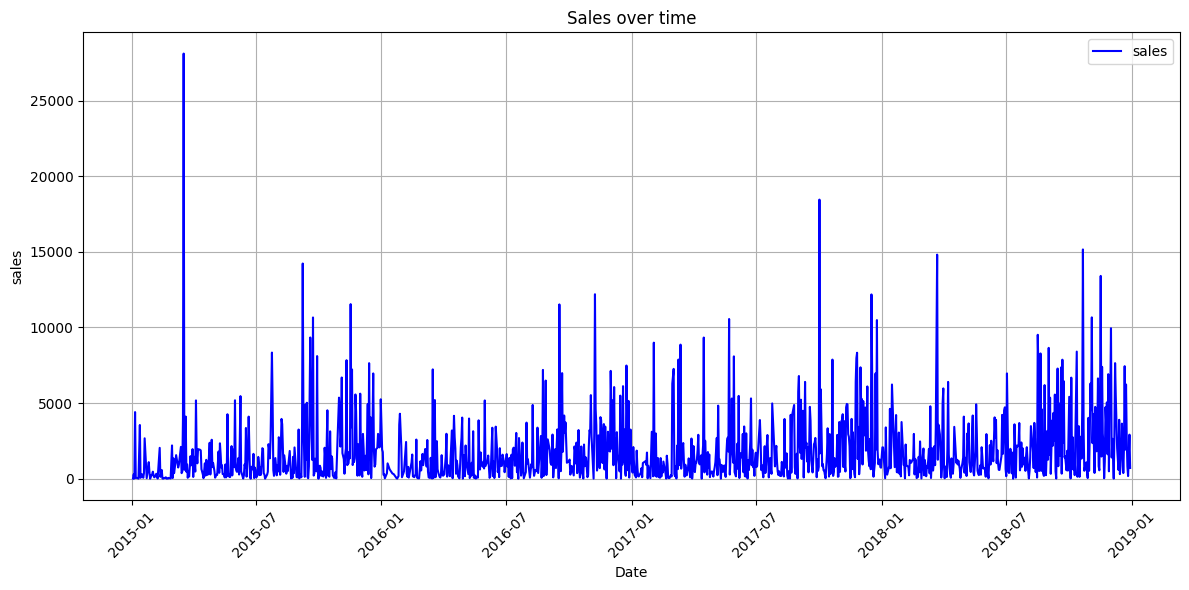

In [6]:
plt.figure(figsize=(12,6))
plt.plot(sales_by_date["order date"],sales_by_date["Sales"],label="sales",color="blue")
plt.title("Sales over time")
plt.xlabel("Date")
plt.ylabel("sales")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Feature Engineering


def lagged_features(data,lag=1):
    lagged_data=data.copy()
    for i in range(1,lag+1):
        lagged_data[f"lag_{i}"]=lagged_data["Sales"].shift(i)
    return lagged_data

lag=5
sales_with_lags=lagged_features(df[["order date","Sales"]],lag)
sales_with_lags=sales_with_lags.dropna()
sales_with_lags.head(n=4)

#This code adds columns that show sales from the previous 5 time periods, so patterns over time can be learned (especially for forecasting).

,order date,Sales,lag_1,lag_2,lag_3,lag_4,lag_5
5,2015-06-09,48.860,22.368,957.5775,14.6200,731.9400,261.9600
6,2015-06-09,7.280,48.860,22.3680,957.5775,14.6200,731.9400
7,2015-06-09,907.152,7.280,48.8600,22.3680,957.5775,14.6200
8,2015-06-09,18.504,907.152,7.2800,48.8600,22.3680,957.5775


In [10]:
# Data for training

X=sales_with_lags.drop(columns=["order date","Sales"])
y=sales_with_lags["Sales"]

X_train, X_test, y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=False)

In [12]:
# We use XGBoost model that uses gradient boosting to creae highly accurate predictive models.

model_xgb=xgb.XGBRegressor(objective="reg:squarederror",n_estimators=100,learning_rate=0.1,max_depth=5)
model_xgb.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [18]:
# Making prediction and Evaluation

predictions=model_xgb.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,predictions))
print(f" Root mean squared error: {rmse:.3f}")

 Root mean squared error: 734.625


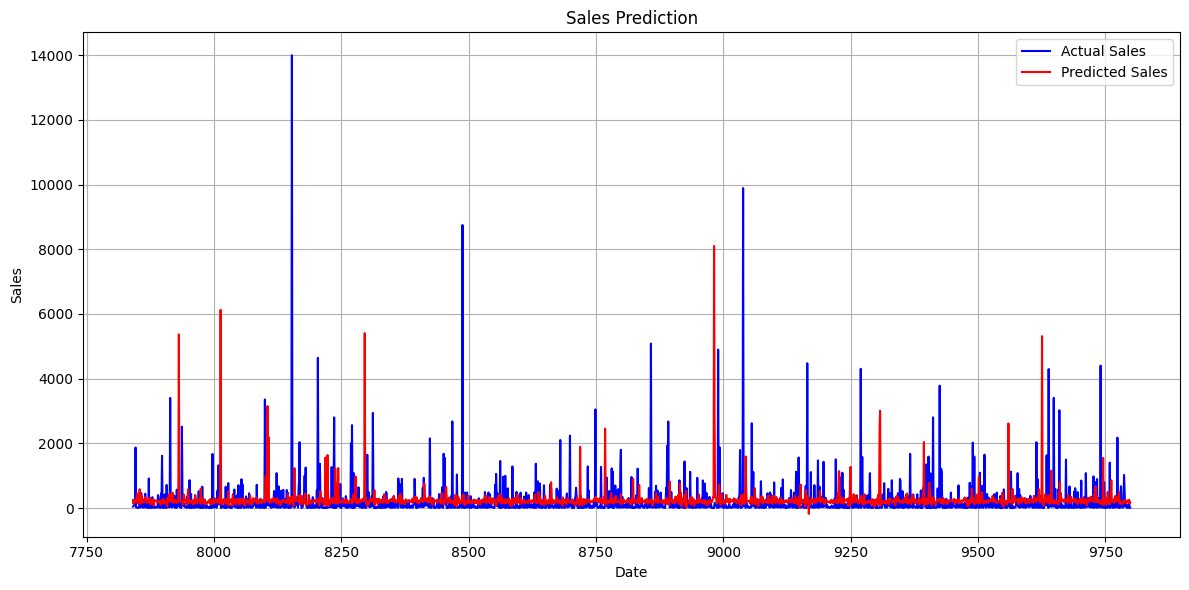

In [20]:
# Visualizing result

plt.figure(figsize=(12,6))
plt.plot(y_test.index,y_test,label="Actual Sales",color="Blue")

plt.plot(y_test.index,predictions,label="Predicted Sales",color="red")
plt.title("Sales Prediction")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

From this figure we can visualize that predicted values and actual values are quite close to each other this proves the efficiency of the model.